In [3]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import os
import sys
sys.path.append("../utils")

from utils_3d import *
from sfm import *

import copy

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/refsys/Desktop/sfm/.venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# load data 

In [ ]:
# sample dataset directory
sample_data_path = "../ImageDataset_SceauxCastle/images/"

K = np.loadtxt(os.path.join(sample_data_path,"K.txt"))

# For calculation Essential Matrix
ims = []

fnames = ["100_7101.JPG","100_7102.JPG","100_7103.JPG"]

for fname in fnames:
    ims.append(cv2.imread(os.path.join(sample_data_path,fname)))

sfm = Sfm(K,np.eye(3),np.zeros(3),ims)
imshow(np.hstack([sfm.views[0].im_gray,sfm.views[1].im_gray,sfm.views[2].im_gray]))

# matching sift

In [5]:
# key point detect view0 and view1
sfm.detectKeyPoints(0)
sfm.detectKeyPoints(1)

In [6]:
# matching keypoint between view1 and view2
match_pair = sfm.matchingKeyPointsOf2views(0,1)
print(len(match_pair))
print(len(sfm.match_manage_table))

# compute essential matrix by ransac epipolar
sfm.solveEpipolarEqToGetEssentialMatrix(0,1)
print(len(sfm.match_manage_table))

Create New matching table
1540
1540
1540
1540


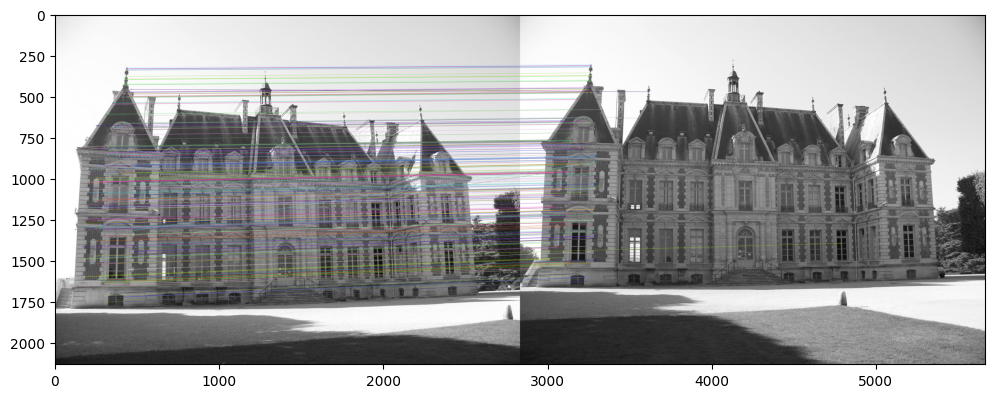

In [7]:
work = sfm
img_good_matches_inliers = cv2.drawMatches(work.views[0].im_gray,work.views[0].key_point_uvs,work.views[1].im_gray,work.views[1].key_point_uvs,match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

# Extract R ,t by Fundamental matrix and K
* F = K^(-T)EK^(-1)
* E = K^(T)FK
* E= [t]xR

In [8]:
w_v1Pv2,v2Rv1,v1Lmks,inlier_mask = sfm.decomposeE2Rt_and_calc_Xs_wrt_v1(0,1)

(1452, 2)
candidate idx:1
inlier mask len: (1452,)
match manage table shape: 1540


# view

[[ 0.99345581 -0.00924757 -0.11384213]
 [ 0.01271568  0.99947572  0.02977584]
 [ 0.11350709 -0.03102857  0.99305255]]
[ 0.97357414 -0.10439577 -0.20311308]


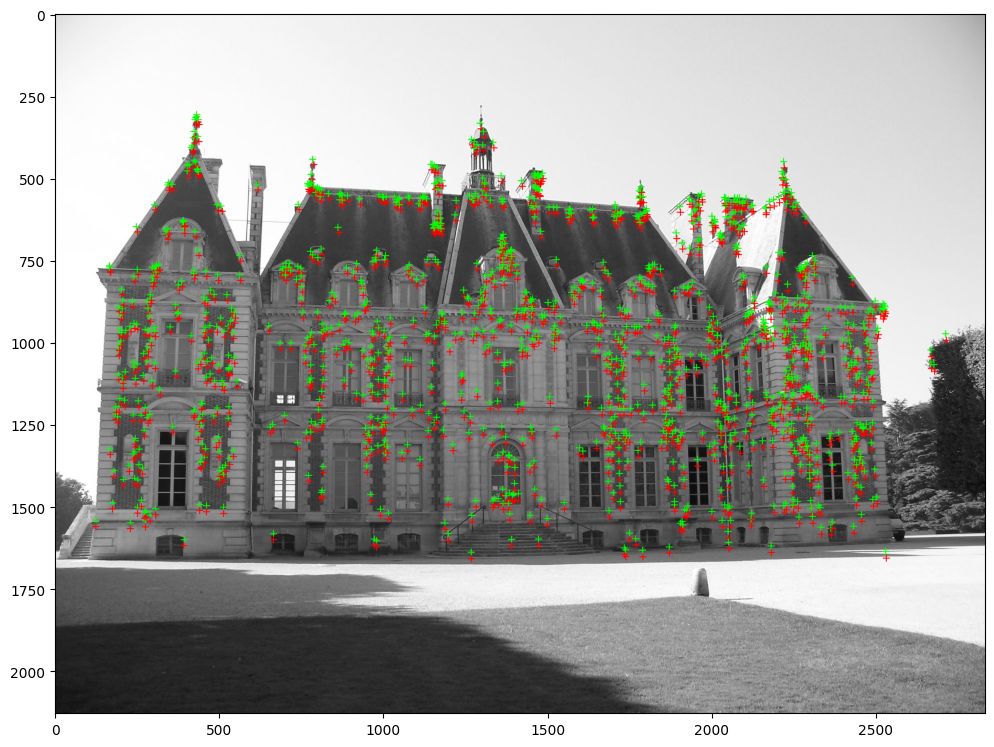

In [9]:
canvas = sfm.check_reprojected_points(1,verbose=False)
imshow(canvas)
print(sfm.views[1].R)
print(sfm.views[1].t)


# Third View PNP

In [10]:
# matching v1 and v2
sfm.detectKeyPoints(2)
v2_v3_match_pair = sfm.matchingKeyPointsOf2views(1,2)

New 1330 points are added.


In [11]:
wPv3,wRv3 = sfm.solvePNPToGet_v1Tv2(1,2)

[ 0.97357414 -0.10439577 -0.20311308]
[-1.52437906  0.11399273  0.42175918]


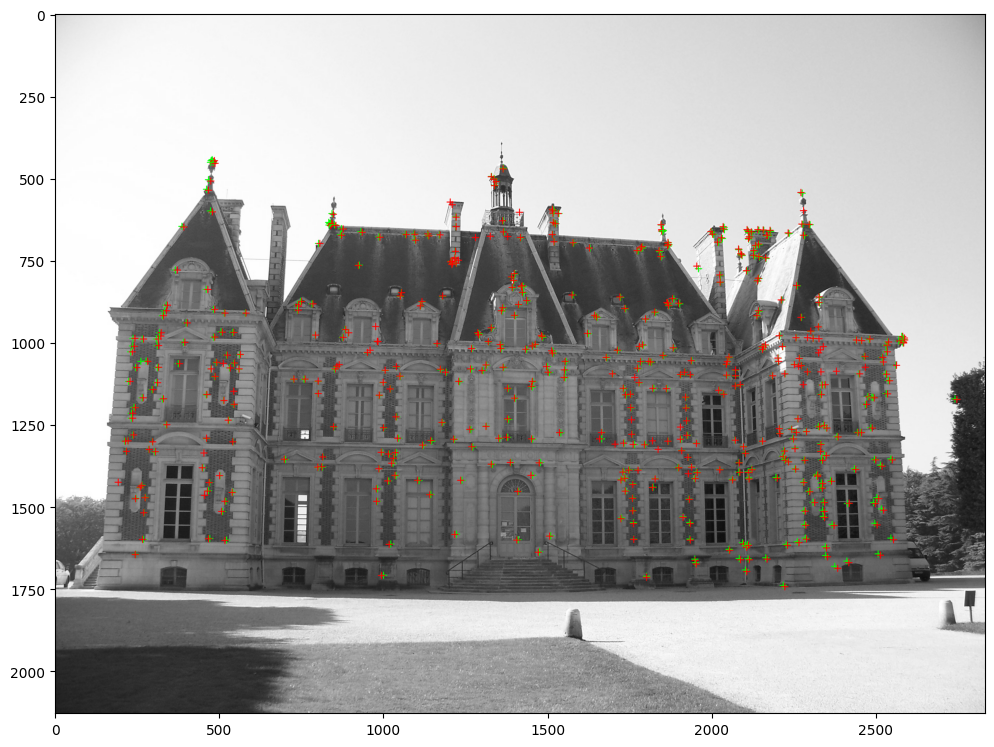

In [13]:
img_good_matches_inliers = cv2.drawMatches(sfm.views[1].im_gray,sfm.views[1].key_point_uvs,sfm.views[2].im_gray,sfm.views[2].key_point_uvs,v2_v3_match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

canvas = sfm.check_reprojected_points(2)
imshow(canvas)

In [15]:
out_pcl_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test2.ply"
out_camera_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera2.ply"

pts2,wLmks,_ = sfm.get2D_3Dcoresspondance(1,2,True)
save_3dpoints_ply(wLmks,out_pcl_file_name,[255,0,0])

Rs = []
Ps = []
for i in range(sfm.numViews):
    R = sfm.views[i].R
    t = sfm.views[i].t
    Rs.append(R)
    Ps.append(t)

Rs = np.array(Rs)
Ps = np.array(Ps)

generate_multiple_camera_ply(Ps,Rs,out_camera_file_name,[0,255,0],False)

# BA

In [16]:
#sfm = BundleAdjust(sfm3view.K)

In [17]:
sfm.make3viewGraphForBA()

(587, 3) 587 (3, 587, 2)
166.83149749356596 1395.3672778455273 [ 168.75289917 1415.39501953]
186.1504944191159 1254.2451013732475 [ 188.70892334 1274.07275391]
193.3057102037986 1288.148261354286 [ 195.58746338 1308.64343262]
193.3057102037986 1288.148261354286 [ 195.58746338 1308.64343262]
197.18854874521912 1252.6858910574638 [ 199.13787842 1272.94482422]
197.32302918873347 1048.189351258411 [ 200.27728271 1067.09814453]
202.97475125090577 946.7100980808855 [206.42100525 965.45977783]
207.87758728325625 1175.055435680494 [ 210.97119141 1194.46435547]
208.769024197343 1157.7830424927206 [ 211.32922363 1177.4486084 ]
207.87402494853916 927.5509759530723 [211.47453308 946.29693604]
210.75420328794098 900.4861960633912 [214.85754395 919.10839844]
215.03136437054098 1232.947328071186 [ 217.12649536 1253.32055664]
217.65717890812792 1138.531539684349 [ 220.6824646  1158.39001465]
221.03250402536418 1001.4662991828532 [ 224.04920959 1021.21105957]
233.0544728345686 1450.8107328763228 [ 234.

In [18]:
sfm.optimizeBA(100)

Performing full BA:


iteration= 0	 chi2= 47940.538834	 time= 0.00713158	 cumTime= 0.00713158	 edges= 1761	 schur= 1	 lambda= 9690.711101	 levenbergIter= 1
iteration= 1	 chi2= 47296.835291	 time= 0.00182381	 cumTime= 0.00895539	 edges= 1761	 schur= 1	 lambda= 3230.237034	 levenbergIter= 1
iteration= 2	 chi2= 47109.982883	 time= 0.00175018	 cumTime= 0.0107056	 edges= 1761	 schur= 1	 lambda= 1076.745678	 levenbergIter= 1
iteration= 3	 chi2= 46971.554574	 time= 0.00152099	 cumTime= 0.0122266	 edges= 1761	 schur= 1	 lambda= 358.915226	 levenbergIter= 1
iteration= 4	 chi2= 46829.786154	 time= 0.00152445	 cumTime= 0.013751	 edges= 1761	 schur= 1	 lambda= 119.638409	 levenbergIter= 1
iteration= 5	 chi2= 46729.794234	 time= 0.00145382	 cumTime= 0.0152048	 edges= 1761	 schur= 1	 lambda= 39.879470	 levenbergIter= 1
iteration= 6	 chi2= 46653.131850	 time= 0.00155571	 cumTime= 0.0167605	 edges= 1761	 schur= 1	 lambda= 13.293157	 levenbergIter= 1
iteration= 7	 chi2= 46572.619894	 time= 0.00153542	 cumTime= 0.018296	 edg

In [19]:
sfm.updatePoseToResultOfBA()

In [20]:

Rs_ba = []
Ps_ba = []
for i in range(3):
    R = sfm.views[i].R_
    t = sfm.views[i].t_
    Rs_ba.append(R)
    Ps_ba.append(t)

Rs_ba = np.array(Rs_ba)
Ps_ba = np.array(Ps_ba)

_,lmks,_ = sfm.getAllviewCoresspondance(True)

(587, 3) 587 (3, 587, 2)


In [21]:
out_pcl_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test6_ba.ply"
out_camera_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera6_ba.ply"

save_3dpoints_ply(lmks,out_pcl_ba_file_name,[100,100,155])
generate_multiple_camera_ply(Ps_ba,Rs_ba,out_camera_ba_file_name,[0,100,155],False)

In [22]:
wPxs_new = sfm.landmark_propagation(1,2)
out_pcl_prop_new_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_prop_new.ply"
save_3dpoints_ply(wPxs_new,out_pcl_prop_new_file_name,[120,0,255])


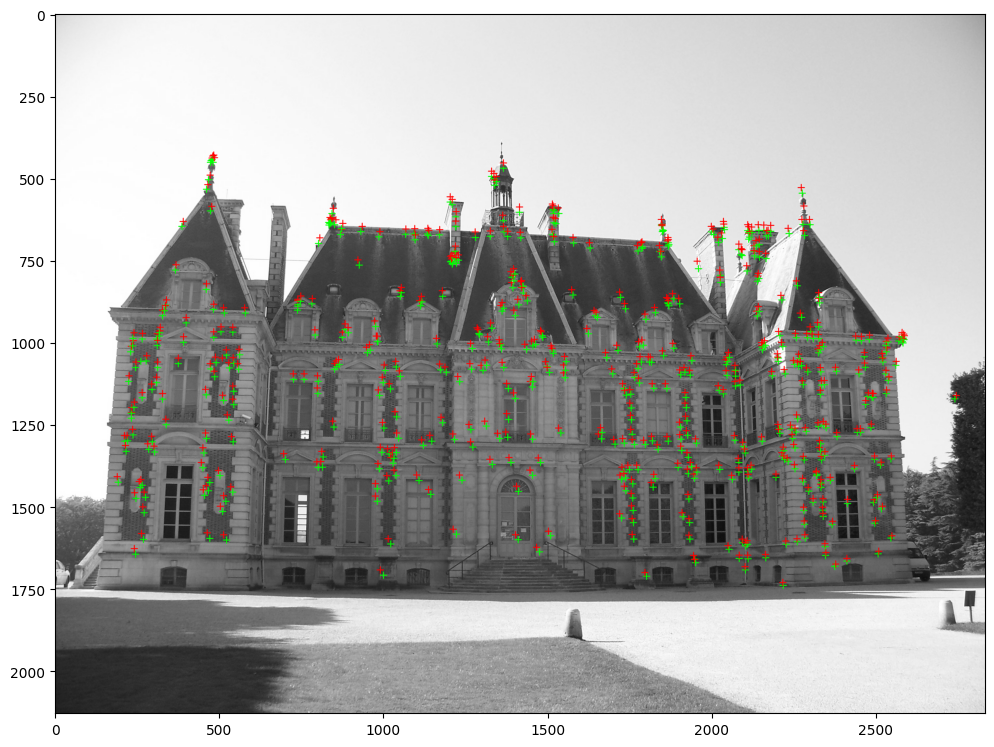

In [23]:
canvas = sfm.check_reprojected_points(2)
imshow(canvas)